## Initial data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample

In [2]:
import numpy as np, matplotlib.pyplot as plt, os
from matplotlib import gridspec
from scipy import ndimage
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from sklearn.datasets import load_digits
try:
    from gtda.time_series import TakensEmbedding, SlidingWindow
    from gtda.homology import VietorisRipsPersistence
    from gtda.plotting import plot_diagram
    HAVE_GIOTTO = True
except Exception:
    HAVE_GIOTTO = False

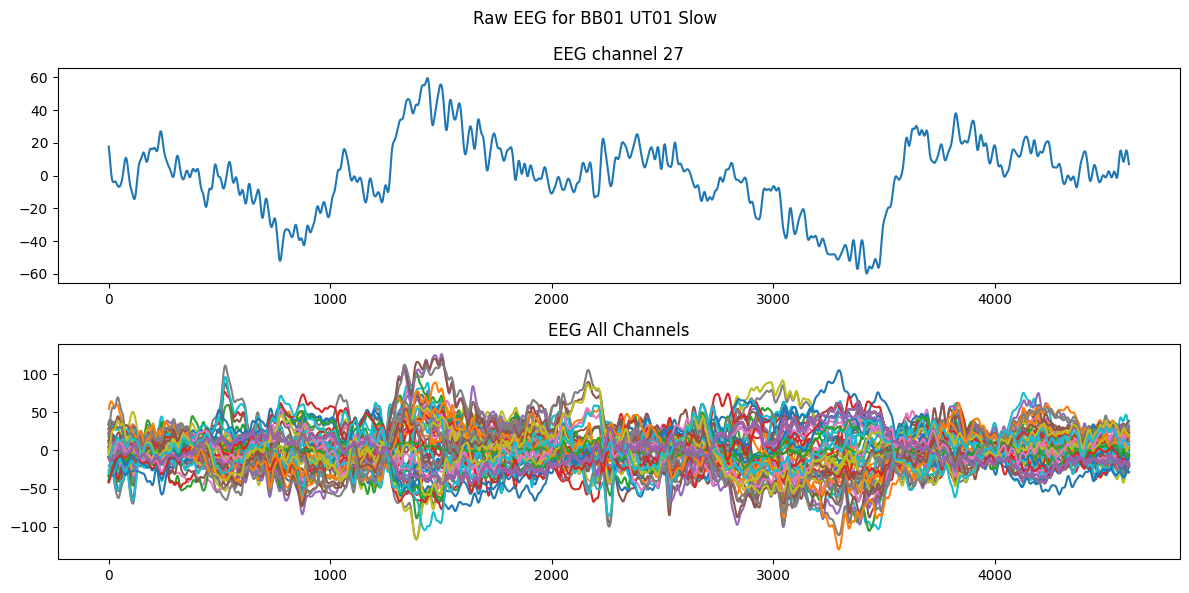

In [3]:
## Select Slow BB01 UT01 for initial testing. This will later be generalized.
data = loadmat('data/sound_sep/slow/bb01_ut01.mat')
eeg = data["subeeg"]
aud = data["y"]
aud = aud[:,0]
Fs = data["Fs"]
fs = 250
fig, axes = plt.subplots(2,1, figsize=(12,6))
axes[0].plot(eeg[:,27])
axes[0].set_title('EEG channel 27')
axes[1].plot(eeg)
axes[1].set_title('EEG All Channels')
fig.suptitle("Raw EEG for BB01 UT01 Slow")
fig.tight_layout()
plt.show()

(4617,)


C:\Users\marti\AppData\Local\Temp\ipykernel_16536\3625882860.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aud_resample = aud[::int(Fs/fs)]


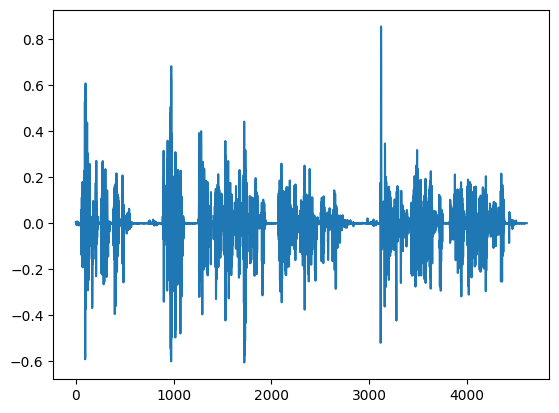

In [4]:
aud_resample = aud[::int(Fs/fs)]
plt.plot(aud_resample)
print(aud_resample.shape)

In [5]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import librosa

# ---------------------------------------------------------
# 1. Hilbert envelope
# ---------------------------------------------------------
def envelope_hilbert(y, sr, smooth_ms=10):
    """Hilbert transform envelope, optionally smoothed with moving average."""
    analytic = hilbert(y)
    env = np.abs(analytic)
    win = int(smooth_ms * sr / 1000)
    if win > 1:
        env = np.convolve(env, np.ones(win)/win, mode='same')
    return env


# ---------------------------------------------------------
# 2. Rectify + Lowpass filter envelope
# ---------------------------------------------------------
def envelope_lowpass(y, sr, cutoff_hz=20, order=4):
    """Envelope via full-wave rectification and Butterworth lowpass."""
    rect = np.abs(y)
    nyq = 0.5 * sr
    b, a = butter(order, cutoff_hz / nyq, btype='low')
    env = filtfilt(b, a, rect)
    return env


# ---------------------------------------------------------
# 3. RMS (root-mean-square) envelope
# ---------------------------------------------------------
def envelope_rms(y, sr, frame_ms=20, hop_ms=None):
    """RMS energy envelope over frames."""
    frame = int(frame_ms * sr / 1000)
    hop = int(hop_ms * sr / 1000) if hop_ms else frame // 2
    rms = librosa.feature.rms(y=y, frame_length=frame, hop_length=hop)[0]
    # Upsample to original signal length
    env = np.repeat(rms, hop)
    return env[:len(y)]


# ---------------------------------------------------------
# 4. Peak interpolation envelope
# ---------------------------------------------------------
def envelope_peaks(y, sr, peak_thresh=0.01, min_dist_ms=5):
    """Envelope by finding peaks and interpolating between them."""
    rect = np.abs(y)
    min_dist = int(min_dist_ms * sr / 1000)
    peaks, _ = find_peaks(rect, height=np.max(rect)*peak_thresh, distance=min_dist)

    if len(peaks) < 2:  # fallback: return rectified signal
        return rect

    xs = np.concatenate(([0], peaks, [len(y)-1]))
    ys = np.concatenate(([rect[0]], rect[peaks], [rect[-1]]))
    f = interp1d(xs, ys, kind='linear')
    env = f(np.arange(len(y)))
    return env


# ---------------------------------------------------------
# 5. Exponential smoothing envelope (attack/release)
# ---------------------------------------------------------
def envelope_exponential(y, sr, attack_ms=1, release_ms=200):
    """Envelope follower with exponential attack/release smoothing."""
    x = np.abs(y)
    a_a = np.exp(-1.0 / (sr * attack_ms / 1000.0))
    a_r = np.exp(-1.0 / (sr * release_ms / 1000.0))
    env = np.zeros_like(x)
    for n in range(1, len(x)):
        coeff = a_a if x[n] > env[n-1] else a_r
        env[n] = coeff * env[n-1] + (1 - coeff) * x[n]
    return env

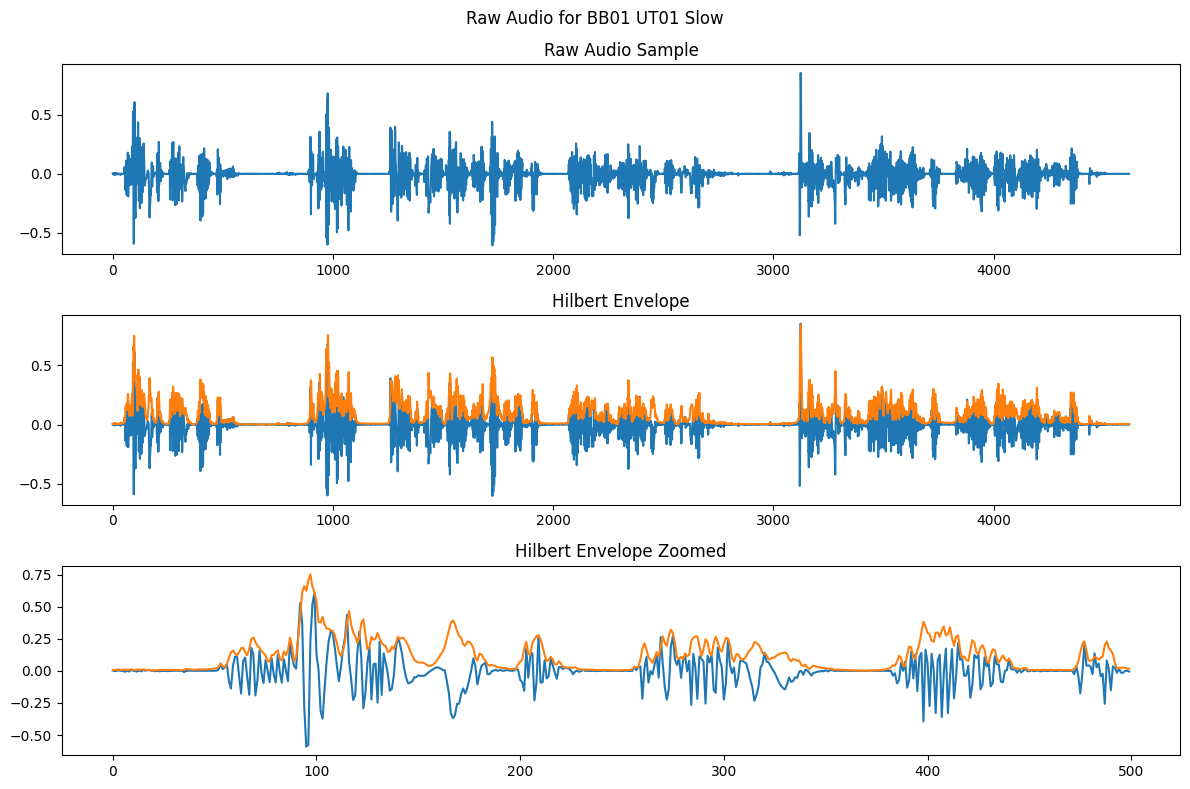

In [6]:
fig, axes = plt.subplots(3,1, figsize=(12,8))
axes[0].plot(aud_resample)
axes[0].set_title("Raw Audio Sample")
axes[1].plot(aud_resample)
axes[1].plot(envelope_hilbert(aud_resample, fs), label='Hilbert')
axes[1].set_title('Hilbert Envelope')
axes[2].plot(aud_resample[:500])
axes[2].plot(envelope_hilbert(aud_resample, fs)[:500], label='Hilbert')
axes[2].set_title('Hilbert Envelope Zoomed')
fig.suptitle("Raw Audio for BB01 UT01 Slow")
fig.tight_layout()
plt.show()

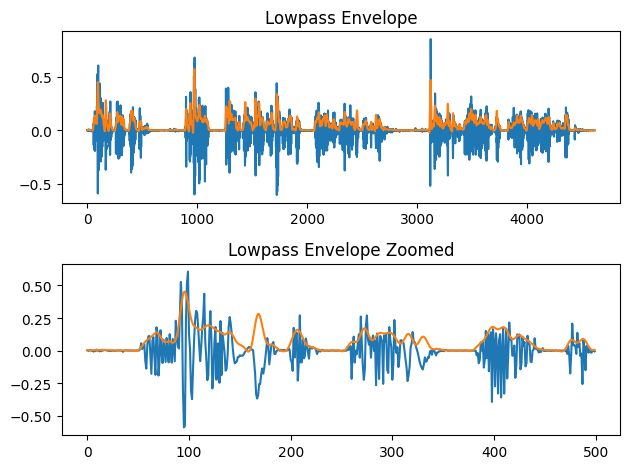

In [7]:
plt.subplot(2,1,1)
plt.plot(aud_resample)
plt.plot(envelope_lowpass(aud_resample, fs), label='Lowpass')
plt.title('Lowpass Envelope')

plt.subplot(2,1,2)
plt.plot(aud_resample[:500])
plt.plot(envelope_lowpass(aud_resample, fs)[:500], label='Lowpass')
plt.title('Lowpass Envelope Zoomed')

plt.tight_layout()
plt.show()

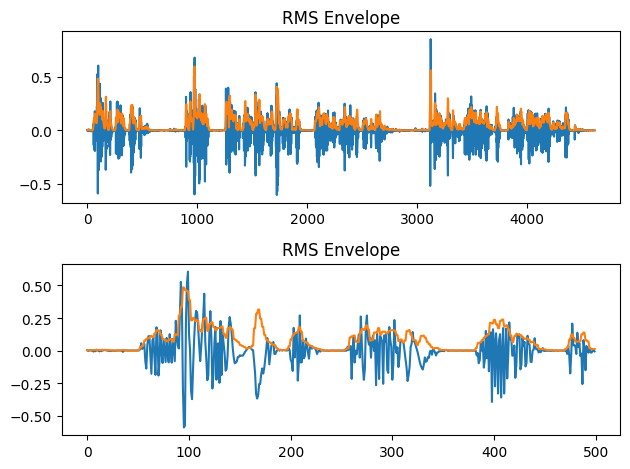

In [8]:
plt.subplot(2,1,1)
plt.plot(aud_resample)
plt.plot(envelope_rms(aud_resample, fs), label='RMS')
plt.title('RMS Envelope')

plt.subplot(2,1,2)
plt.plot(aud_resample[:500])
plt.plot(envelope_rms(aud_resample, fs)[:500], label='RMS')
plt.title('RMS Envelope')

plt.tight_layout()
plt.show()

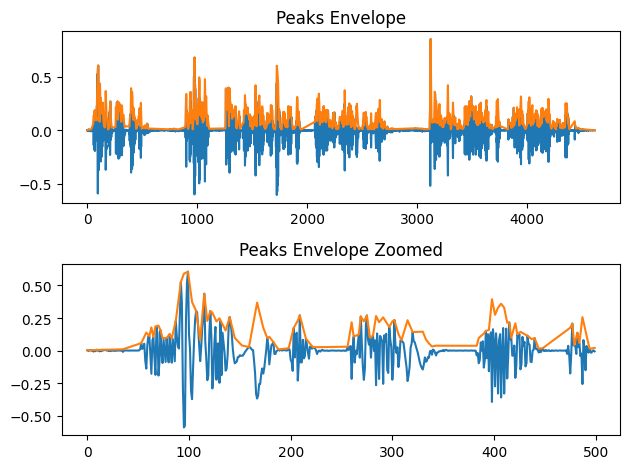

In [9]:
plt.subplot(2,1,1)
plt.plot(aud_resample)
plt.plot(envelope_peaks(aud_resample, fs), label='Peaks')
plt.title('Peaks Envelope')

plt.subplot(2,1,2)
plt.plot(aud_resample[:500])
plt.plot(envelope_peaks(aud_resample, fs)[:500], label='Peaks')
plt.title('Peaks Envelope Zoomed')

plt.tight_layout()
plt.show()

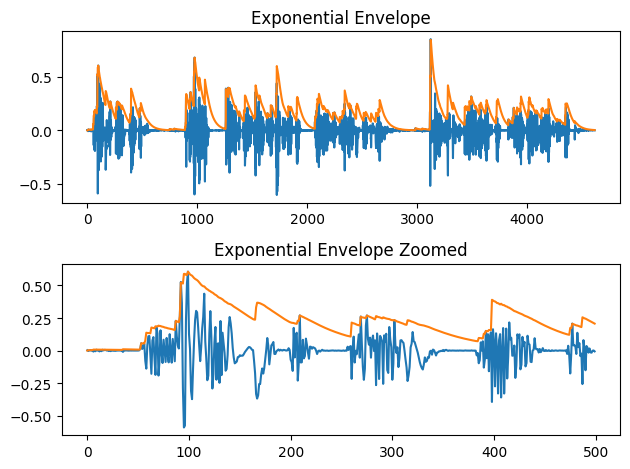

In [10]:
plt.subplot(2,1,1)
plt.plot(aud_resample)
plt.plot(envelope_exponential(aud_resample, fs), label='Exponential')
plt.title('Exponential Envelope')

plt.subplot(2,1,2)
plt.plot(aud_resample[:500])
plt.plot(envelope_exponential(aud_resample, fs)[:500], label='Exponential')
plt.title('Exponential Envelope Zoomed')

plt.tight_layout()
plt.show()

In [11]:
aud_dict = {
    'audio': aud_resample,
    'hilbert': envelope_hilbert(aud_resample, Fs),
    'lowpass': envelope_lowpass(aud_resample, Fs),
    'rms': envelope_rms(aud_resample, Fs),
    'peaks': envelope_peaks(aud_resample, Fs),
    'exponential': envelope_exponential(aud_resample, Fs)
}

C:\Users\marti\AppData\Local\Temp\ipykernel_16536\1440202765.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  win = int(smooth_ms * sr / 1000)
C:\Users\marti\AppData\Local\Temp\ipykernel_16536\1440202765.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  frame = int(frame_ms * sr / 1000)
C:\Users\marti\AppData\Local\Temp\ipykernel_16536\1440202765.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_dist = int(min_dist_ms * sr / 1000)
C:\Users\marti\AppDa

In [12]:
with open('GSN-HydroCel-65.sfp', 'r') as f:
    lines = f.readlines()

In [13]:
print("".join(lines))

FidNz      0.00000      10.3556     -2.69376
FidT9     -7.18083    0.0461216     -3.71184
FidT10      6.24270    0.0461216     -3.71184
E1      6.60688      6.30230     -2.94229
E2      4.41106      8.71481      3.50199
E3      3.27490      8.15713      5.69580
E4      0.00000      4.34559      9.00826
E5      3.07692      10.1424      1.24235
E6      0.00000      9.08970      5.75876
E7     -2.78065      3.71493      8.68573
E8      0.00000      10.3612      3.54499
E9     -3.2749      8.15713      5.6958
E10     -3.07692      10.1424      1.24235
E11     -4.41106      8.71481      3.50199
E12     -5.09058      6.87341      4.98320
E13     -6.48687      6.22527      3.23806
E14     -6.33176      4.74636      5.28262
E15     -5.43625      3.07969      7.18905
E16     -4.21856      1.09635      8.70749
E17     -6.60688      6.30230     -2.94229
E18     -7.30483      4.71143    -0.407362
E19     -7.78984      3.38858      2.77404
E20     -6.25466     0.325281      7.28684
E21     -4.4633

## Sliding Window on Audio Files

In [14]:
def cubical_pd_from_image(img):
    cc = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    cc.compute_persistence()
    D0 = np.array(cc.persistence_intervals_in_dimension(0))
    D1 = np.array(cc.persistence_intervals_in_dimension(1))
    return [D0, D1]

def gudhi_rips_diagrams(X, maxdim=1, max_edge_length=None):
    max_edge = np.inf if max_edge_length is None else max_edge_length
    rc = gd.RipsComplex(points=X, max_edge_length=max_edge)
    st = rc.create_simplex_tree(max_dimension=maxdim+1)
    st.compute_persistence() # [(dim, [birth, death])]
    dgms = []
    # como gudhi tiene los intervalos (dim, [birth, death]) lo homogenizamos con el formato de ripser
    # una lista de listas de intervalos
    for dim in range(maxdim+1):
        d = st.persistence_intervals_in_dimension(dim)
        # Gudhi usa 'inf' para muertes infinitas; lo dejamos así para compatibilidad con persim
        dgms.append(np.array(d, dtype=float))
    return dgms

def takens_numpy(x, m=3, tau=10):
    """Takens embedding simple para una serie 1D -> matriz (N-(m-1)tau, m)."""
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    return np.vstack([x[i:i+N] for i in range(0, m*tau, tau)]).T

(4617,)


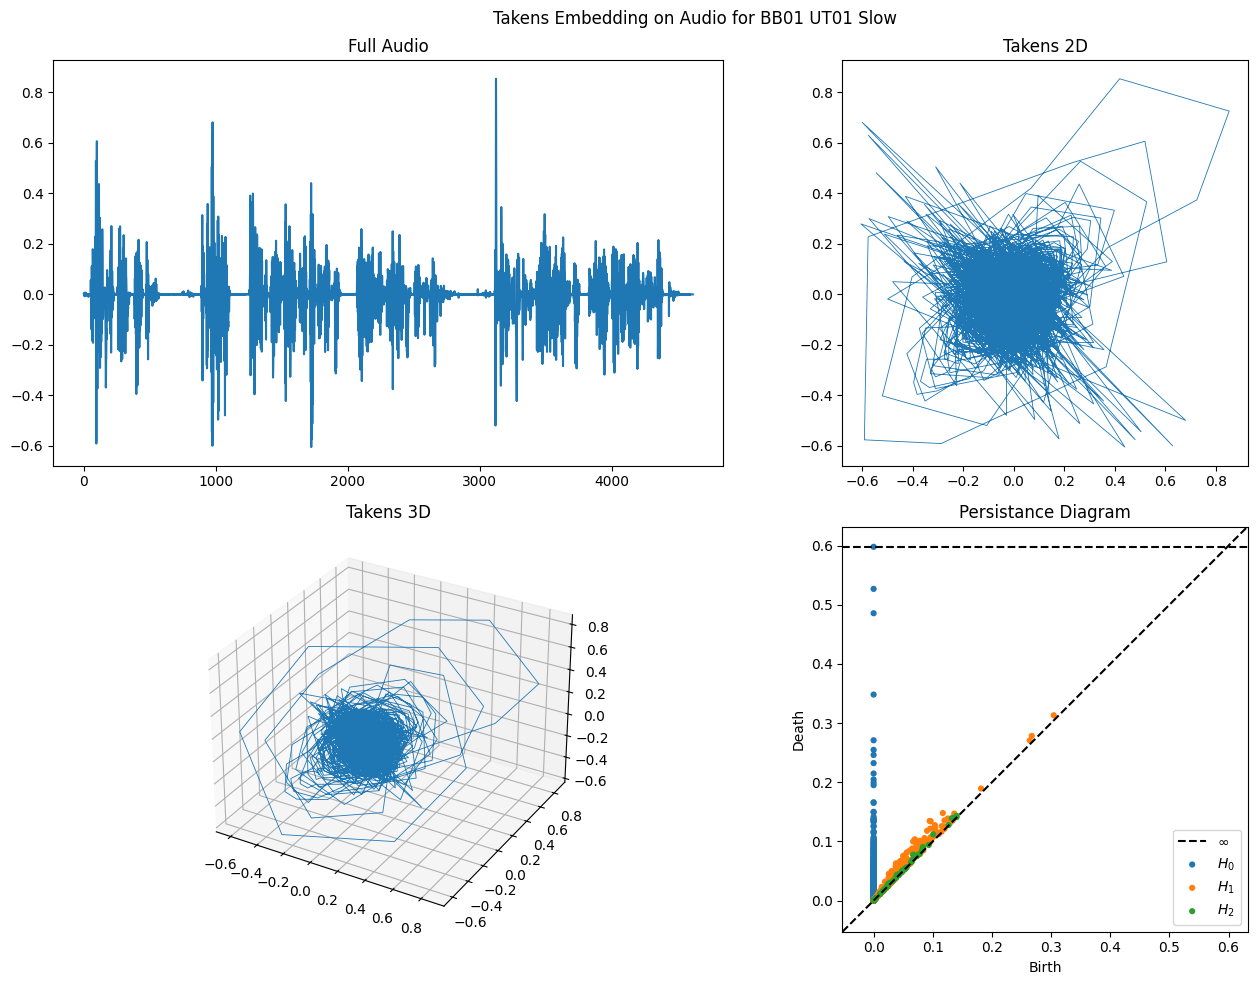

In [15]:
#aud_dict["hilbert"]

print(aud_dict["audio"].shape)

# considera average_week_data para los ejercicios A y B

# Parameters for the Takens' embedding or Slidding windows embedding
d = 3  # A common starting value
tau = 1  # A common starting value

x_series = aud_dict["audio"]
t = range(len(x_series))

emb2 = takens_numpy(x_series, m=2, tau=tau)
emb3 = takens_numpy(x_series, m=3, tau=tau)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(221); ax.plot(x_series); ax.set_title("Full Audio")
ax = fig.add_subplot(222); ax.plot(emb2[:,0], emb2[:,1], lw=0.6); ax.set_title("Takens 2D"); ax.set_aspect('equal')
ax = fig.add_subplot(223, projection='3d'); ax.plot(emb3[:,0], emb3[:,1], emb3[:,2], lw=0.6); ax.set_title("Takens 3D")

# Persistencia (submuestreo para rapidez)
idx = np.arange(0, len(emb3), 5)
D_emb = ripser(emb3[idx], maxdim=2)['dgms']
ax = fig.add_subplot(224); plot_diagrams(D_emb, ax=ax, show=False); ax.set_title("Persistance Diagram")

fig.suptitle("Takens Embedding on Audio for BB01 UT01 Slow"); plt.tight_layout(); plt.show()

(4617,)


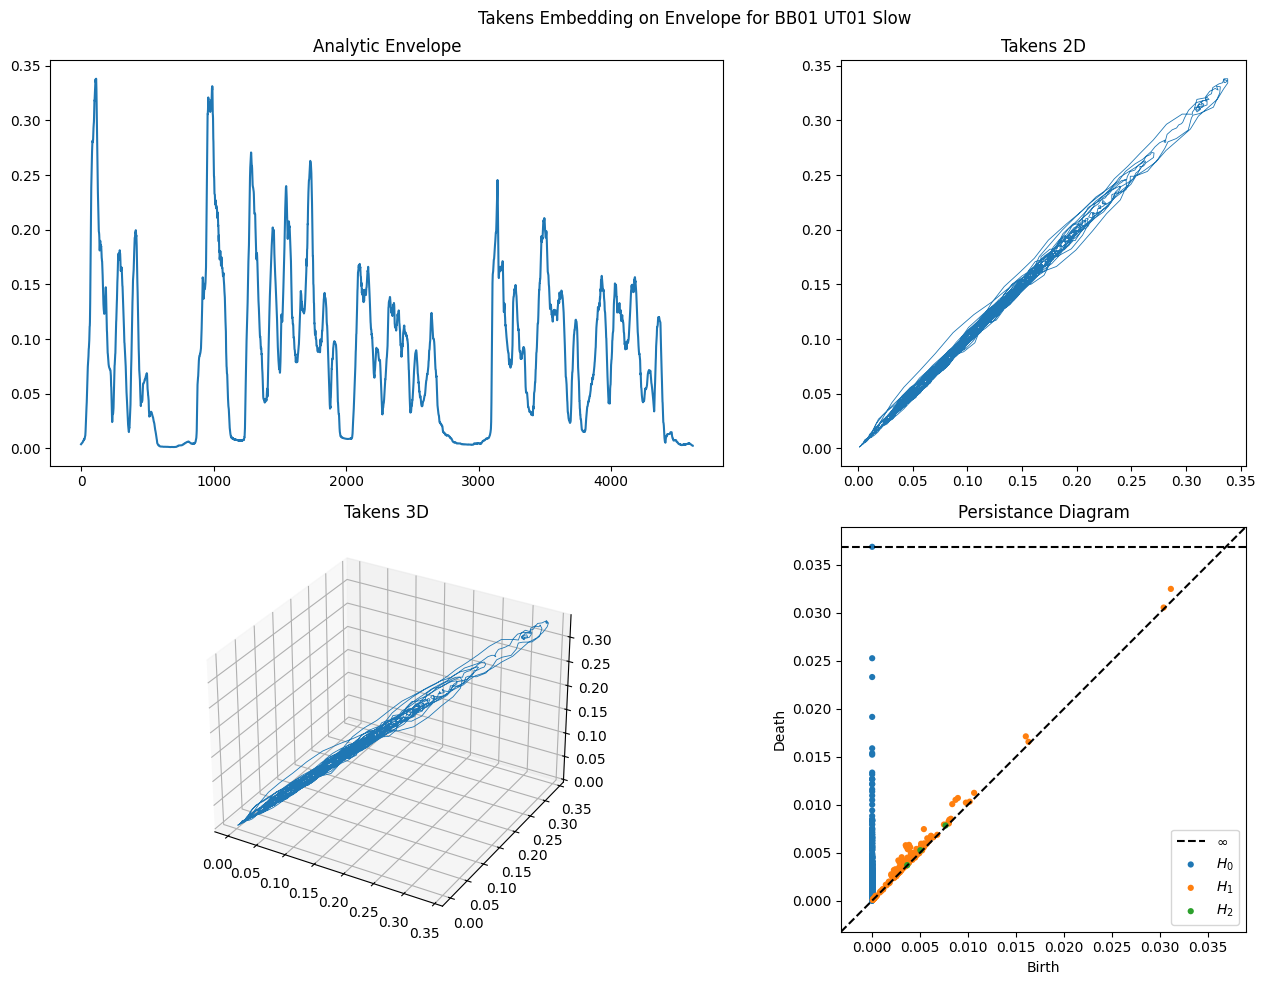

In [17]:
#aud_dict["hilbert"]

print(aud_dict["hilbert"].shape)

# considera average_week_data para los ejercicios A y B

# Parameters for the Takens' embedding or Slidding windows embedding
d = 3  # A common starting value
tau = 1  # A common starting value

x_series = aud_dict["hilbert"]
t = range(len(x_series))

emb2 = takens_numpy(x_series, m=2, tau=tau)
emb3 = takens_numpy(x_series, m=3, tau=tau)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(221); ax.plot(x_series); ax.set_title("Analytic Envelope")
ax = fig.add_subplot(222); ax.plot(emb2[:,0], emb2[:,1], lw=0.6); ax.set_title("Takens 2D"); ax.set_aspect('equal')
ax = fig.add_subplot(223, projection='3d'); ax.plot(emb3[:,0], emb3[:,1], emb3[:,2], lw=0.6); ax.set_title("Takens 3D")

# Persistencia (submuestreo para rapidez)
idx = np.arange(0, len(emb3), 5)
D_emb = ripser(emb3[idx], maxdim=2)['dgms']
ax = fig.add_subplot(224); plot_diagrams(D_emb, ax=ax, show=False); ax.set_title("Persistance Diagram")

fig.suptitle("Takens Embedding on Envelope for BB01 UT01 Slow");plt.tight_layout(); plt.show()